In [ ]:
# Running differential expression on TAM clusters

Had to install new software (diffxpy), hence the new notebook

In [34]:
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import pandas as pd
import scipy.stats
import diffxpy.api as de

ModuleNotFoundError: No module named 'scanpy'

In [3]:
from batchglm.api.models.tf1.glm_nb import Simulator

sim = Simulator(num_observations=200, num_features=100)
sim.generate_sample_description(num_batches=0, num_conditions=2)
sim.generate_params(
    rand_fn_loc=lambda shape: np.random.uniform(-0.1, 0.1, shape),
    rand_fn_scale=lambda shape: np.random.uniform(0.1, 2, shape)
)
sim.generate_data()

sim_data = ad.AnnData(
    X=sim.x,
    var=pd.DataFrame(index=["gene" + str(i) for i in range(sim.x.shape[1])]),
    obs=sim.sample_description
)

/tmp/ipykernel_3001799/3295157826.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sim_data = ad.AnnData(
/mnt/isilon/cscb/software/anaconda3/envs/diffxpy/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [24]:
sim_data.obs['condition'].unique()

array(['0', '1'], dtype=object)

In [3]:
data = ad.read_h5ad('NBL_TAM_clustering.h5ad')

/mnt/isilon/cscb/software/anaconda3/envs/diffxpy/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
data

AnnData object with n_obs × n_vars = 138131 × 398
    obs: 'cluster', 'x', 'y', 'global_x', 'global_y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden', 'cell_type', 'TAM_cluster'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
tam_data = data[data.obs['cell_type']=='Macrophage_TAM', :]
tam_data

View of AnnData object with n_obs × n_vars = 10761 × 398
    obs: 'cluster', 'x', 'y', 'global_x', 'global_y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden', 'cell_type', 'TAM_cluster'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
tam_data.obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10761 entries, 306 to 218261
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   cluster            10761 non-null  int64   
 1   x                  10761 non-null  float64 
 2   y                  10761 non-null  float64 
 3   global_x           10761 non-null  float64 
 4   global_y           10761 non-null  float64 
 5   n_genes            10761 non-null  int64   
 6   n_genes_by_counts  10761 non-null  int64   
 7   total_counts       10761 non-null  float32 
 8   leiden             10761 non-null  category
 9   cell_type          10761 non-null  category
 10  TAM_cluster        10761 non-null  category
dtypes: category(3), float32(1), float64(4), int64(3)
memory usage: 1004.5+ KB


In [5]:
tam_data.obs['TAM_cluster'] = tam_data.obs['TAM_cluster'].astype("category")

/tmp/ipykernel_1510077/1158798154.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tam_data.obs['TAM_cluster'] = tam_data.obs['TAM_cluster'].astype("category")


In [6]:
data.X = data.raw.X

In [39]:
data.var.describe()

,n_cells,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,mean,std
count,398.000000,398.000000,398.000000,398.000000,3.980000e+02,398.000000,398.000000
mean,28311.477387,28311.477387,0.479629,83.921333,8.445361e+04,0.855996,1.355940
std,27942.950245,27942.950245,0.945998,15.869373,1.665723e+05,0.941918,0.659219
min,490.000000,490.000000,0.002794,28.452814,4.920000e+02,0.012222,0.212181
25%,6009.500000,6009.500000,0.045451,74.545380,8.003000e+03,0.162315,0.795742
50%,17350.000000,17350.000000,0.160662,90.146580,2.828950e+04,0.487047,1.330270
75%,44820.750000,44820.750000,0.473457,96.587082,8.336675e+04,1.290792,1.928228
max,125981.000000,125981.000000,7.763580,99.721719,1.367019e+06,4.872831,2.901155


In [7]:
# need to get the raw values back
tam_data.X = tam_data.raw.X

In [15]:
tam_data

AnnData object with n_obs × n_vars = 10761 × 398
    obs: 'cluster', 'x', 'y', 'global_x', 'global_y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden', 'cell_type', 'TAM_cluster'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
# np.quantile(tam_data.X, np.arange(0,1,0.1)) # wow, so a lot of zeros...or very little variation
np.quantile(data.X, np.arange(0,1,0.1))

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 4.2412281])

In [14]:
np.quantile(np.apply_along_axis(lambda x: np.sum(x>0), 0, tam_data.X), np.arange(0,1,0.1))


array([  16. ,   99.7,  176. ,  314.5,  491.4,  734.5, 1149.8, 1679.9,
       2727.6, 4085.1])

In [9]:
# got a float division by zero error, there are likely genes not observed in any of the TAMs
# maybe drop genes appearing in less than 100 cells
# tam_data_filter = tam_data[:, np.sum(tam_data.X, axis=0)>200]
tam_data_filter = tam_data[:, np.apply_along_axis(lambda x: np.sum(x>0) > 100, 0, tam_data.X),]
tam_data_filter

View of AnnData object with n_obs × n_vars = 10761 × 357
    obs: 'cluster', 'x', 'y', 'global_x', 'global_y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden', 'cell_type', 'TAM_cluster'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
tam_data_filter.obs.TAM_cluster = tam_data_filter.obs.TAM_cluster.astype("category")

/mnt/isilon/cscb/software/anaconda3/envs/diffxpy/lib/python3.10/site-packages/pandas/core/generic.py:5604: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


<AxesSubplot:ylabel='n_cells_by_counts'>

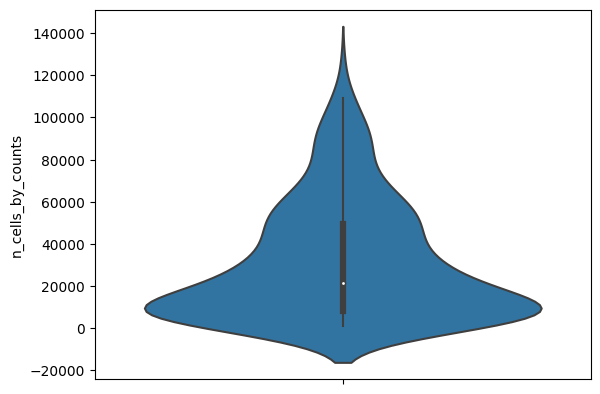

In [41]:
sns.violinplot(y=tam_data_filter.var['n_cells_by_counts'])
# sns.violinplot(y=tam_data_filter.obs['total_counts'])


In [38]:
tam_data_filter.var['n_cells'].min()

929

In [35]:
# test = de.test.wald(
#     data=sim_data,
#     formula_loc="~ 1 + condition",
#     factor_loc_totest="condition"
# )
test = de.test.wald(
    data=tam_data_filter,
    formula_loc="~ 1 + TAM_cluster",
    factor_loc_totest="TAM_cluster",
)
# test = de.test.wald(
#     data=data,
#     formula_loc="~ 1 + cell_type",
#     factor_loc_totest="cell_type"
# )

training location model: False
training scale model: True
iter   0: ll=10905796.440218
iter   1: ll=10905796.440218, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=10752247.254412, converged: 0.28% (loc: 0.28%, scale update: True), in 4.92sec
iter   3: ll=10752247.254412, converged: 0.28% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=10751410.295593, converged: 99.72% (loc: 99.72%, scale update: True), in 4.91sec
iter   5: ll=10751410.295593, converged: 99.72% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=10751410.295593, converged: 100.00% (loc: 100.00%, scale update: True), in 0.08sec


ZeroDivisionError: float division by zero

In [ ]:
test.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=0.05, size=20)

In [36]:
tam_data_filter.obs.head()

,cluster,x,y,global_x,global_y,n_genes,n_genes_by_counts,total_counts,leiden,cell_type,TAM_cluster
306,2,8515.943753,47619.711195,919.722549,5142.932294,39,39,80.0,4,Macrophage_TAM,2
312,1,8539.087320,47701.801517,922.222055,5151.798054,53,53,134.0,4,Macrophage_TAM,2
318,1,8511.821859,47774.222197,919.277384,5159.619493,47,47,89.0,4,Macrophage_TAM,2
360,2,8743.063968,48191.985063,944.251548,5204.737913,32,32,105.0,4,Macrophage_TAM,2
366,2,8820.508178,48193.363867,952.615529,5204.886824,42,42,66.0,4,Macrophage_TAM,2


In [22]:
test_tt = de.test.t_test(
    data=tam_data_filter,
    grouping="TAM_cluster",
    is_logged=True
)

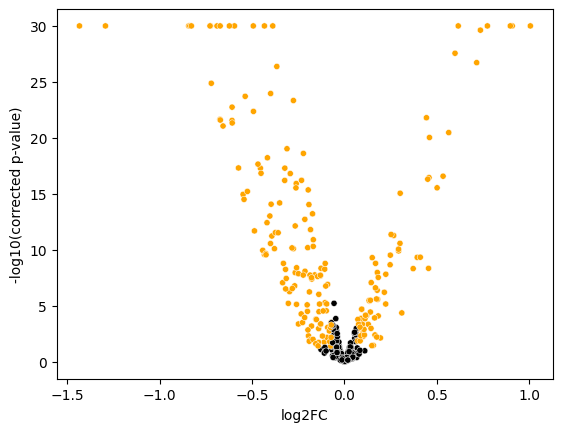

In [12]:
test_tt.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=0.05, size=20, save="outs/TAM_volcano.png")


In [12]:
test_tt.summary().to_csv("outs/TAM_DEG_results.csv")

In [28]:
tam_data_filter.obs.TAM_cluster.categories

AttributeError: 'Series' object has no attribute 'categories'

In [31]:
test_lrt = de.test.lrt(
   data=tam_data_filter, 
   full_formula_loc="1+TAM_cluster",
   reduced_formula_loc="1"
)

ValueError: type <class 'tuple'> not recognized

In [32]:
tam_data_filter.obs.TAM_cluster.unique()

[2, 1]
Categories (2, int64): [1, 2]

## What's the background DEG of TAM vs everything else?

In [14]:
data.obs.head()

,cluster,x,y,global_x,global_y,n_genes,n_genes_by_counts,total_counts,leiden,cell_type,TAM_cluster
1,3,9814.177667,34514.342452,1059.931906,3727.551510,28,28,48.0,1,Adrn_Cortex,0
2,3,9682.431879,34771.178573,1045.703352,3755.289830,39,39,66.0,1,Adrn_Cortex,0
3,1,9885.160007,34576.806317,1067.598004,3734.297613,94,94,264.0,10,Adrenergic,0
4,2,9191.688652,35310.791135,992.703047,3813.568027,39,39,64.0,1,Adrn_Cortex,0
5,3,9628.535631,34824.350603,1039.882553,3761.032413,75,75,186.0,2,Adrenergic,0


In [15]:
data.obs.cell_type.unique()

['Adrn_Cortex', 'Adrenergic', 'T_Cell', 'Fibroblast', 'NK_Cell', 'Endothelial', 'Macrophage_TAM', 'B_Cell', 'unknown']
Categories (9, object): ['Adrenergic', 'Adrn_Cortex', 'B_Cell', 'Endothelial', ..., 'Macrophage_TAM', 'NK_Cell', 'T_Cell', 'unknown']

In [16]:
data.obs['is_TAM'] = data.obs['cell_type'] == 'Macrophage_TAM'

In [17]:
data.obs['is_TAM'] = data.obs['is_TAM'].astype('category')

In [18]:
test_tt = de.test.t_test(
    data=data,
    grouping="is_TAM",
    is_logged=True
)

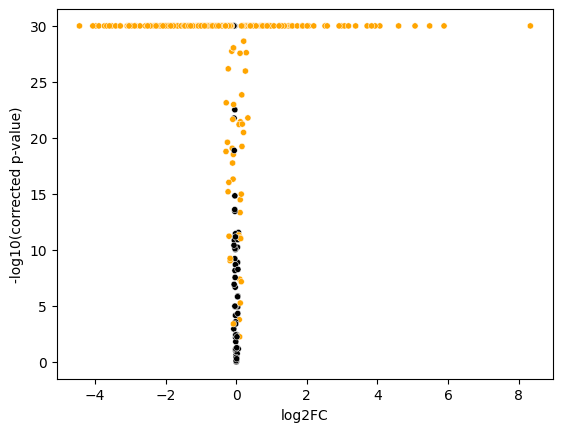

In [19]:
test_tt.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=0.05, size=20)

In [20]:
test_tt.summary().to_csv("outs/global_MAC_DEG_results.csv")

### Previous results aren't helpful

In [31]:
# load scanpy mac. marker
deg_in = pd.read_csv("outs/global_mac_DEG.csv")
mac_markers = deg_in['Macrophage_TAM'][0:40]

In [26]:
deg_res = test_tt.summary()
deg_res.set_index('gene', inplace=True)

In [32]:
deg_res.loc[mac_markers, :].to_csv('outs/TAM_cluster_deg_SignatureFilter.csv')